# Group Assignment #4
### By Veronica De Santos Quezada

## Who’s Most at Risk? Social Demographics and Traffic Collisions in the City of Los Angeles
This notebook examines the Spatial Autocorrelation Analysis of fatalities (bike and pedestrians) in the City of Los Angeles from 2015-2019 using UC Berkeley's Transportation Injury Mapping System (TIMS) data.

## Data Sources & Geographic Information
2019 Census Tracts from IPUMS NHGIS (At the time, we could not download the TIGER/Shapefile due to federal government actions).

2015 - 2019 UC Berkeley - TIMS

# Libraries

In [12]:
# data exploration 
import pandas as pd

# merge data 
import geopandas as gpd

# basemaps
import contextily as ctx

# spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps  

# importing for plots and tables 
import matplotlib.pyplot as plt
import plotly.express as px

In [13]:
# importing census tracts
la_tracts = gpd.read_file('data_midterm/cityLA.zip')

In [14]:
# upload ACS 2015-2019 - To include Total Population
total_population = pd.read_csv('data_midterm/race15_19.csv')

In [15]:
#converting FIPS, STATE, and COUNTY from integer to string & reintegrate leading zero
total_population = pd.read_csv('data_midterm/race15_19.csv', 
                   dtype=
                   {'Geo_FIPS': str, 
                  'Geo_STATE': str, 
                  'Geo_COUNTY': str })

In [16]:
#cleaning total population data
columns_to_keep = ['Geo_FIPS', 
                   'Geo_STATE', 
                   'Geo_COUNTY',
                   'Geo_TRACT',
                   'SE_B04001_001']

total_population = total_population[columns_to_keep] 

In [17]:
#rename columns 
total_population.columns = ['FIPS',
                'State',
                'County',
                'Census Tract',
                'Total Population']

In [18]:
#checking dataframe
total_population.head(2)

FIPS State County  Census Tract  Total Population
0  06037101110    06    037        101110              4283
1  06037101122    06    037        101122              3405

## Merge Data

In [19]:
# add a FIPS column
# creating a new column so that I can merge the shapefile and census tracts
la_tracts['FIPS'] = '06' + '037' + la_tracts['TRACTCE']

In [20]:
# merge to create a new dataframe 
la_city = la_tracts.merge(total_population, on="FIPS")

In [21]:
#checking that data merged
la_city.head(2)

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID     NAME  \
0  G0600370101110      06      037  101110  06037101110  1011.10   
1  G0600370101122      06      037  101122  06037101122  1011.22   

               NAMELSAD  MTFCC FUNCSTAT      ALAND  ...      INTPTLON  \
0  Census Tract 1011.10  G5020        S  1142401.0  ...  -118.2929869   
1  Census Tract 1011.22  G5020        S  2644045.0  ...  -118.2901465   

    Shape_Leng   Shape_Le_1    Shape_Area  \
0  4585.520052  4585.520052  1.142400e+06   
1  9652.233049  9652.233049  2.644046e+06   

                                            geometry         FIPS State  \
0  POLYGON ((-2019033.589 -124429.155, -2018948.5...  06037101110    06   
1  POLYGON ((-2017297.948 -125225.326, -2017305.0...  06037101122    06   

  County Census Tract Total Population  
0    037       101110             4283  
1    037       101122             3405  

[2 rows x 22 columns]

In [22]:
#cleaning the data for necessary columns 
columns_to_keep_la = ['FIPS', 
                   'Total Population', 
                   'geometry']

la_city = la_city[columns_to_keep_la]

In [23]:
# identifying total population row to delete; there is no total population column 
la_city.tail()

FIPS  Total Population  \
1163  06037980026                26   
1164  06037980028                 0   
1165  06037980030                 0   
1166  06037980031              1175   
1167  06037980033                16   

                                               geometry  
1163  POLYGON ((-2017734.652 -121289.969, -2017604.1...  
1164  POLYGON ((-2037371.498 -155528.944, -2037368.6...  
1165  POLYGON ((-2039470.503 -159401.276, -2039585.4...  
1166  MULTIPOLYGON (((-2027306.945 -179844.798, -202...  
1167  MULTIPOLYGON (((-2027800.331 -180973.621, -202...

In [24]:
# modifuing total population to numerical values to fix sorting issue (the column was not sorting)
la_city['Total Population'] = pd.to_numeric(la_city['Total Population'], errors='coerce')
la_city.sort_values(by='Total Population', ascending=True).head(20)

FIPS  Total Population  \
1165  06037980030                 0   
1164  06037980028                 0   
1008  06037320000                 0   
1149  06037980002                 0   
1158  06037980020                 0   
1160  06037980022                 0   
1161  06037980023                 0   
1154  06037980013                 0   
1150  06037980005                 0   
1148  06037980001                 0   
1152  06037980009                 5   
1155  06037980014                 9   
1167  06037980033                16   
1163  06037980026                26   
1159  06037980021                33   
1032  06037532400                45   
1151  06037980008                68   
1146  06037930101                90   
1065  06037575500                93   
1153  06037980010                95   

                                               geometry  
1165  POLYGON ((-2039470.503 -159401.276, -2039585.4...  
1164  POLYGON ((-2037371.498 -155528.944, -2037368.6...  
1008  MULTIPOLYGON (((-2026987.276 -137679.181, -202...  
1149  MULTIPOLYGON (((-2025190.604 -177036.987, -202...  
1158  POLYGON ((-2019136.183 -127669.077, -2019102.7...  
1160  POLYGON ((-2034697.534 -114703.299, -2034687.1...  
1161  POLYGON ((-2047272.84 -120824.771, -2047312.73...  
1154  MULTIPOLYGON (((-2034925.473 -159035.208, -203...  
1150  POLYGON ((-2030557.304 -168200.728, -2030641.3...  
1148  MULTIPOLYGON (((-2026441.139 -130545.925, -202...  
1152  POLYGON ((-2022567.042 -135317.48, -2022521.63...  
1155  POLYGON ((-2023897.332 -173566.566, -2023897.0...  
1167  MULTIPOLYGON (((-2027800.331 -180973.621, -202...  
1163  POLYGON ((-2017734.652 -121289.969, -2017604.1...  
1159  POLYGON ((-2025428.836 -121670.065, -2025123.7...  
1032  MULTIPOLYGON (((-2016109.903 -153887.653, -201...  
1151  POLYGON ((-2037999.512 -124659.921, -2037596.7...  
1146  MULTIPOLYGON (((-2013586.944 -124850.593, -201...  
1065  MULTIPOLYGON (((-2024641.672 -178266.284, -202...  
1153  POLYGON ((-2018570.594 -143801.843, -2018563.2...

In [25]:
# deleting entries where the total population is less than 100
la_city = la_city[la_city['Total Population']>100]

# Bicycle Collisions TIMS Data Analysis

In [26]:
# upload crash data 
# use pandas since we do not have geometry data 
bike = pd.read_csv('data_midterm/bike_crashes_tims.csv')

In [27]:
# convert data to geodataframe to plot 
bike = gpd.GeoDataFrame(bike, 
                         crs ='EPSG:4326', 
                         geometry=gpd.points_from_xy(bike.POINT_X, bike.POINT_Y))

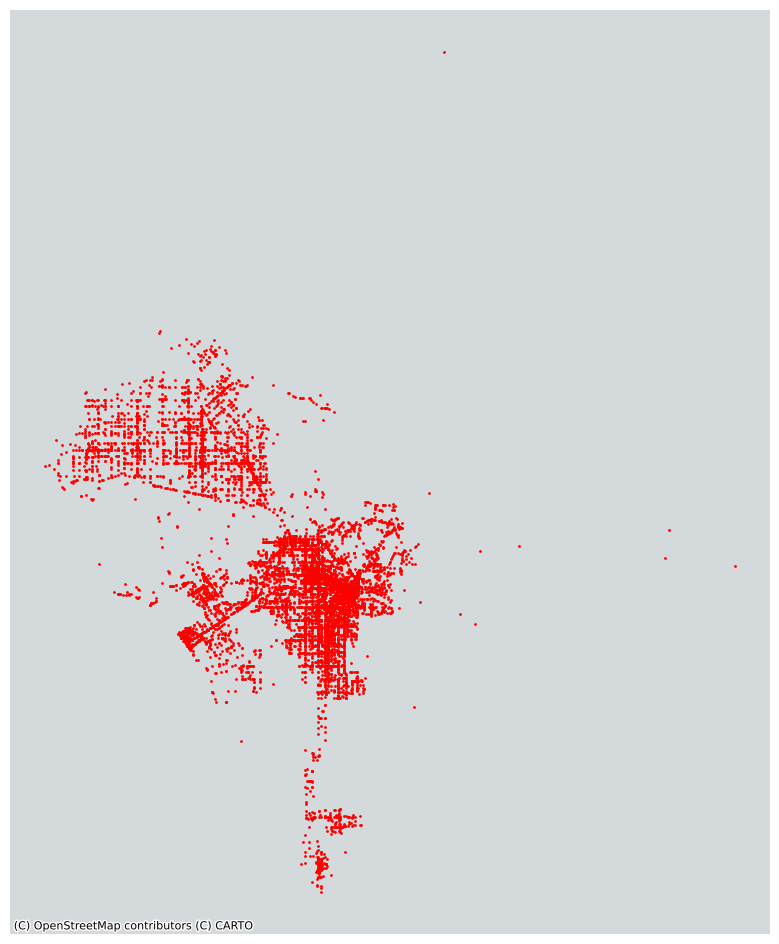

In [28]:
# map crash data
fig,ax = plt.subplots(figsize=(12,12))

bike.plot(ax=ax,
             color='red',
             markersize=1)

ax.axis('off')

ctx.add_basemap(ax,zoom=12, source=ctx.providers.CartoDB.Positron)

In [29]:
# calculating the bounds for crash data 
# purpose - we want to zoom into the crash layer and NOT census tracts 
minx, miny, maxx, maxy = bike.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-118.66132108
-117.72847747802734
33.70698011
34.64589


In [30]:
#joining census tracrts and bicycle collisions
bike = bike.to_crs(epsg=3857)
la_city = la_city.to_crs(epsg=3857)
join = gpd.sjoin(la_city, bike, how='left')

In [31]:
# checking my dataset
join.head(5)

FIPS  Total Population  \
0  06037101110              4283   
1  06037101122              3405   
2  06037101210              6347   
2  06037101210              6347   
3  06037101220              3702   

                                            geometry  index_right    CASE_ID  \
0  POLYGON ((-13168864.246 4064201.311, -13168757...        593.0  6908180.0   
1  POLYGON ((-13166582.527 4063754.258, -13166586...          NaN        NaN   
2  POLYGON ((-13167528.967 4063214.44, -13167528....        852.0  6953470.0   
2  POLYGON ((-13167528.967 4063214.44, -13167528....       9463.0  9024371.0   
3  POLYGON ((-13167423.881 4063213.632, -13167369...       8194.0  8863409.0   

   ACCIDENT_YEAR   PROC_DATE   JURIS COLLISION_DATE  COLLISION_TIME  ...  \
0         2015.0  2015-05-18  1942.0     2015-04-23          1740.0  ...   
1            NaN         NaN     NaN            NaN             NaN  ...   
2         2015.0  2015-06-17  1942.0     2015-05-30          1030.0  ...   
2         2019.0  2020-01-16  1942.0     2019-11-17          2250.0  ...   
3         2019.0  2019-05-22  1942.0     2019-04-11          1500.0  ...   

  COUNT_MC_KILLED COUNT_MC_INJURED  PRIMARY_RAMP  SECONDARY_RAMP  LATITUDE  \
0             0.0              0.0            -               -        NaN   
1             NaN              NaN           NaN             NaN       NaN   
2             0.0              0.0            -               -        NaN   
2             0.0              0.0            -               -        NaN   
3             0.0              0.0            -               -        NaN   

   LONGITUDE       COUNTY         CITY     POINT_X    POINT_Y  
0        NaN  LOS ANGELES  LOS ANGELES -118.288510  34.262810  
1        NaN          NaN          NaN         NaN        NaN  
2        NaN  LOS ANGELES  LOS ANGELES -118.297940  34.254540  
2        NaN  LOS ANGELES  LOS ANGELES -118.286064  34.248035  
3        NaN  LOS ANGELES  LOS ANGELES -118.281799  34.247799  

[5 rows x 84 columns]

In [32]:
# creating new dataframe for bicycle collision by census tract
crash_by_bike = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='Bicycle Collision Count')
crash_by_bike

FIPS  Bicycle Collision Count
0     06037226002                      171
1     06037207710                      106
2     06037224700                       88
3     06037224020                       87
4     06037207900                       83
...           ...                      ...
1143  06037701201                        1
1144  06037701000                        1
1145  06037700902                        1
1146  06037104103                        1
1147  06037103300                        1

[1148 rows x 2 columns]

# Statistics

In [33]:
# descriptive stats for bicycle collisions. On average each census tract has had 11 bicycle collision.
crash_by_bike ['Bicycle Collision Count'].describe()

count    1148.000000
mean        8.342334
std        11.016927
min         1.000000
25%         2.000000
50%         5.000000
75%        11.000000
max       171.000000
Name: Bicycle Collision Count, dtype: float64

In [34]:
# merging census tracts with bicycle collisions 
la_city=la_city.merge(crash_by_bike,on='FIPS')

In [35]:
# checking for my merged dataset
la_city.head(10)

FIPS  Total Population  \
0  06037101110              4283   
1  06037101122              3405   
2  06037101210              6347   
3  06037101220              3702   
4  06037101300              3884   
5  06037101400              3458   
6  06037102103              1763   
7  06037102104              3721   
8  06037102105              1905   
9  06037102107              4349   

                                            geometry  Bicycle Collision Count  
0  POLYGON ((-13168864.246 4064201.311, -13168757...                        1  
1  POLYGON ((-13166582.527 4063754.258, -13166586...                        1  
2  POLYGON ((-13167528.967 4063214.44, -13167528....                        2  
3  POLYGON ((-13167423.881 4063213.632, -13167369...                        5  
4  POLYGON ((-13165229.103 4062741.029, -13165229...                        1  
5  POLYGON ((-13169034.788 4063225.626, -13168864...                        6  
6  POLYGON ((-13173921.826 4059171.99, -13173936....                        2  
7  POLYGON ((-13173332.61 4058687.307, -13173367....                        1  
8  POLYGON ((-13173883.427 4056571.41, -13173900....                        1  
9  POLYGON ((-13172435.269 4063723.845, -13172429...                        4

In [36]:
# new column "killed_per_1000" - the crash/killed rate 
la_city['collision_per_1000'] = la_city['Bicycle Collision Count']/la_city['Total Population']*1000

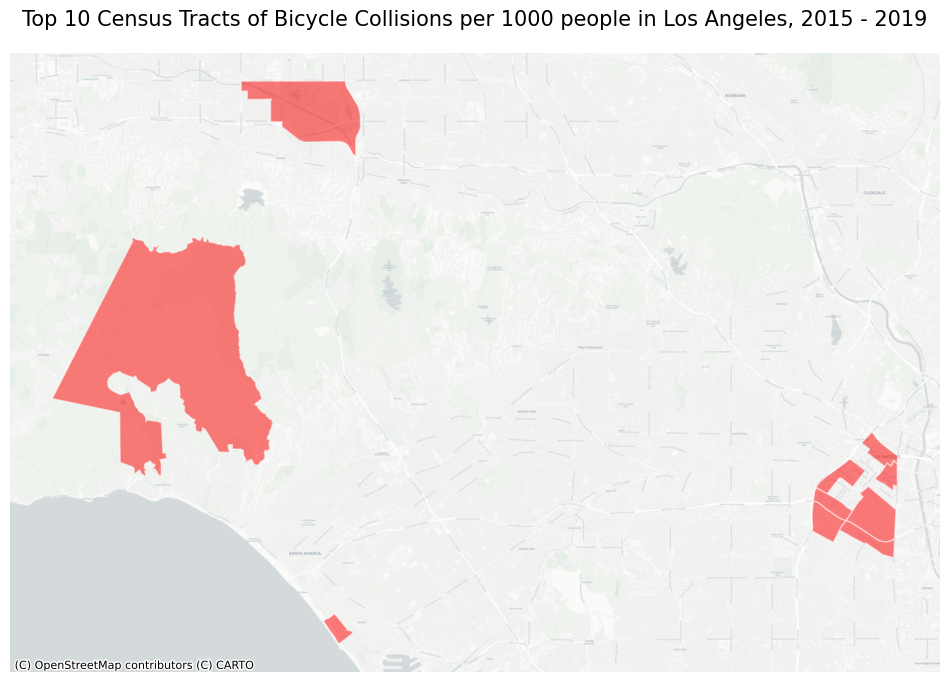

In [37]:
# seeing the location of the top 10 places of bicycle collison
fig,ax = plt.subplots(figsize=(12,12))
la_city.sort_values(by='collision_per_1000',ascending=False)[:10].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5)


# title
ax.set_title('Top 10 Census Tracts of Bicycle Collisions per 1000 people in Los Angeles, 2015 - 2019',fontsize=15,pad=20)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax, zoom=14, source=ctx.providers.CartoDB.Positron)

<Axes: ylabel='Frequency'>

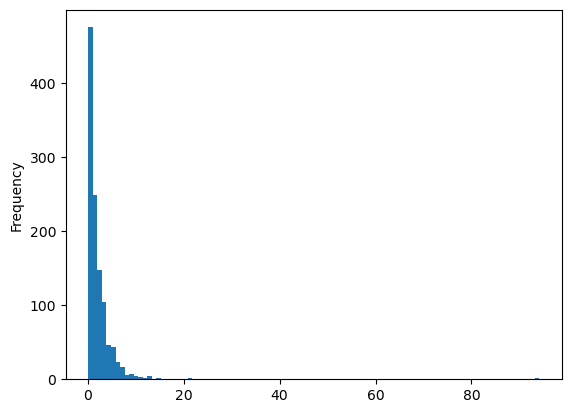

In [38]:
# identifying skew to determine mapping approach
la_city['collision_per_1000'].plot.hist(bins=100)

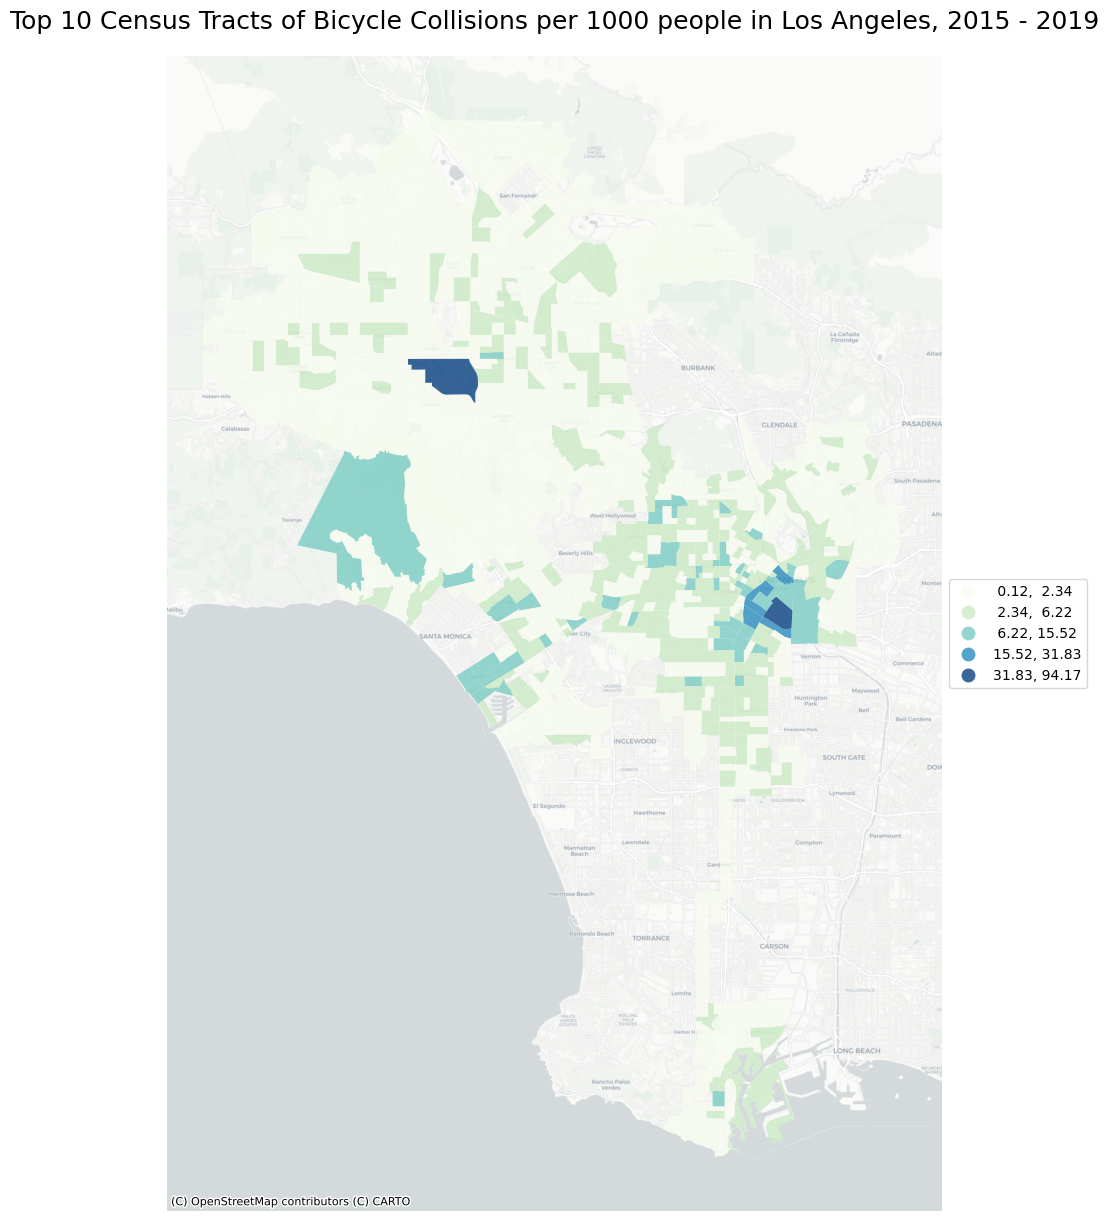

In [39]:
# using natural breaks for choropleth map 
fig,ax = plt.subplots(figsize=(15,15))

la_city.plot(ax=ax,  
        column='collision_per_1000',
        legend=True,
        alpha=0.8,    
        cmap='GnBu', 
        scheme='naturalbreaks',
        legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})

ax.axis('off')
ax.set_title('Top 10 Census Tracts of Bicycle Collisions per 1000 people in Los Angeles, 2015 - 2019',fontsize=18,pad=20)
ctx.add_basemap(ax, zoom= 12,source=ctx.providers.CartoDB.Positron)

In [40]:
# creating interactive map of the same data presented above
la_city.explore(column='collision_per_1000', 
        legend=True,
        cmap='GnBu', 
        scheme='naturalbreaks',
        tiles='CartoDB positron',
        style_kwds={
            'weight':0.5,
            'color':'black',
            'opacity':0.5
        })

# Spatial Weights

In [41]:
# calculating spatial weight 
wq =  lps.weights.KNN.from_dataframe(la_city,k=8)

In [42]:
# row standardization
wq.transform = 'r'

In [43]:
# spatial lag
la_city['collision_per_1000_lag']=lps.weights.lag_spatial(wq, la_city['collision_per_1000'])

In [44]:
#review sample 
la_city.sample(10)

FIPS  Total Population  \
474   06037195901              2237   
454   06037192700              3449   
797   06037240010              3737   
891   06037271500              3187   
1006  06037311700              6200   
199   06037124400              4858   
151   06037121010              4934   
234   06037128101              3735   
605   06037212410              4318   
533   06037206032              5687   

                                               geometry  \
474   POLYGON ((-13166910.71 4041223.923, -13166906....   
454   POLYGON ((-13167366.34 4040031.251, -13167365....   
797   POLYGON ((-13165699.513 4023446.54, -13165537....   
891   POLYGON ((-13183591.248 4030936.847, -13183688...   
1006  MULTIPOLYGON (((-13170725.093 4049535.763, -13...   
199   POLYGON ((-13181762.425 4052917.12, -13181652....   
151   POLYGON ((-13180683.946 4059958.06, -13180626....   
234   POLYGON ((-13183706.959 4054872.478, -13183706...   
605   POLYGON ((-13169208.242 4037094.809, -13169196...   
533   POLYGON ((-13159904.201 4035052.994, -13159967...   

      Bicycle Collision Count  collision_per_1000  collision_per_1000_lag  
474                         1            0.447027                3.268917  
454                        11            3.189330                2.926120  
797                         8            2.140755                1.999908  
891                         8            2.510198                2.939504  
1006                        1            0.161290                0.652313  
199                         8            1.646768                1.931469  
151                         8            1.621403                1.612806  
234                         9            2.409639                1.419999  
605                        15            3.473830                4.046998  
533                        20            3.516793                4.914557

In [45]:
# calculating the difference between between killed_per_1000 and the spatial lag ; and sorting the data
la_city['collision_lag_diff'] = la_city['collision_per_1000'] - la_city['collision_per_1000_lag']
la_city.sort_values(by='collision_lag_diff')

FIPS  Total Population  \
546   06037207900              7162   
224   06037127605              4329   
261   06037132101              4645   
536   06037206300              6103   
325   06037139701              5320   
...           ...               ...   
545   06037207710              4667   
542   06037207400              1539   
693   06037224020              2733   
702   06037226002              1820   
1146  06037980024               223   

                                               geometry  \
546   POLYGON ((-13164323.023 4034580.051, -13164263...   
224   POLYGON ((-13189783.028 4054868.219, -13189540...   
261   POLYGON ((-13190512.062 4054867.417, -13190374...   
536   POLYGON ((-13162206.389 4034613.643, -13162218...   
325   POLYGON ((-13189536.919 4051003.355, -13189537...   
...                                                 ...   
545   POLYGON ((-13163727.46 4035352.957, -13163875....   
542   POLYGON ((-13162761.548 4036500.813, -13162689...   
693   POLYGON ((-13164642.616 4032982.265, -13164651...   
702   POLYGON ((-13162261.931 4033499.971, -13162283...   
1146  POLYGON ((-13192455.041 4053888.365, -13192239...   

      Bicycle Collision Count  collision_per_1000  collision_per_1000_lag  \
546                        83           11.588942               24.921898   
224                         5            1.155001               13.211316   
261                         5            1.076426               13.131888   
536                        76           12.452892               23.423398   
325                         9            1.691729               12.389706   
...                       ...                 ...                     ...   
545                       106           22.712663                6.437430   
542                        39           25.341131                8.002396   
693                        87           31.833150                8.338410   
702                       171           93.956044                9.947900   
1146                       21           94.170404                1.597451   

      collision_lag_diff  
546           -13.332957  
224           -12.056315  
261           -12.055462  
536           -10.970506  
325           -10.697976  
...                  ...  
545            16.275233  
542            17.338735  
693            23.494741  
702            84.008144  
1146           92.572953  

[1148 rows x 7 columns]

In [46]:
# FIPS with the highest negative difference ; look at areas and try to identify potential factors
la_city_donut = la_city.sort_values(by='collision_lag_diff').head(1)
la_city_donut

FIPS  Total Population  \
546  06037207900              7162   

                                              geometry  \
546  POLYGON ((-13164323.023 4034580.051, -13164263...   

     Bicycle Collision Count  collision_per_1000  collision_per_1000_lag  \
546                       83           11.588942               24.921898   

     collision_lag_diff  
546          -13.332957

In [47]:
# FIPS with the highest positive difference 
la_city_diamond = la_city.sort_values(by='collision_lag_diff').tail(1)
la_city_diamond

FIPS  Total Population  \
1146  06037980024               223   

                                               geometry  \
1146  POLYGON ((-13192455.041 4053888.365, -13192239...   

      Bicycle Collision Count  collision_per_1000  collision_per_1000_lag  \
1146                       21           94.170404                1.597451   

      collision_lag_diff  
1146           92.572953

# Satellite imagery

In [48]:
# creating a map using satellite imagery, this image describes the census tract that has a low bicycle collision count while surrounding tracts have higher bicycle collision counts. 
la_city_donut.explore(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                  attr= 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

In [49]:
# creating a map using satellite imagery, this image describes the census tract that has a high bicycle collision count while surrounding tracts have a lower bicycle collision counts. 
la_city_diamond.explore(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                  attr= 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

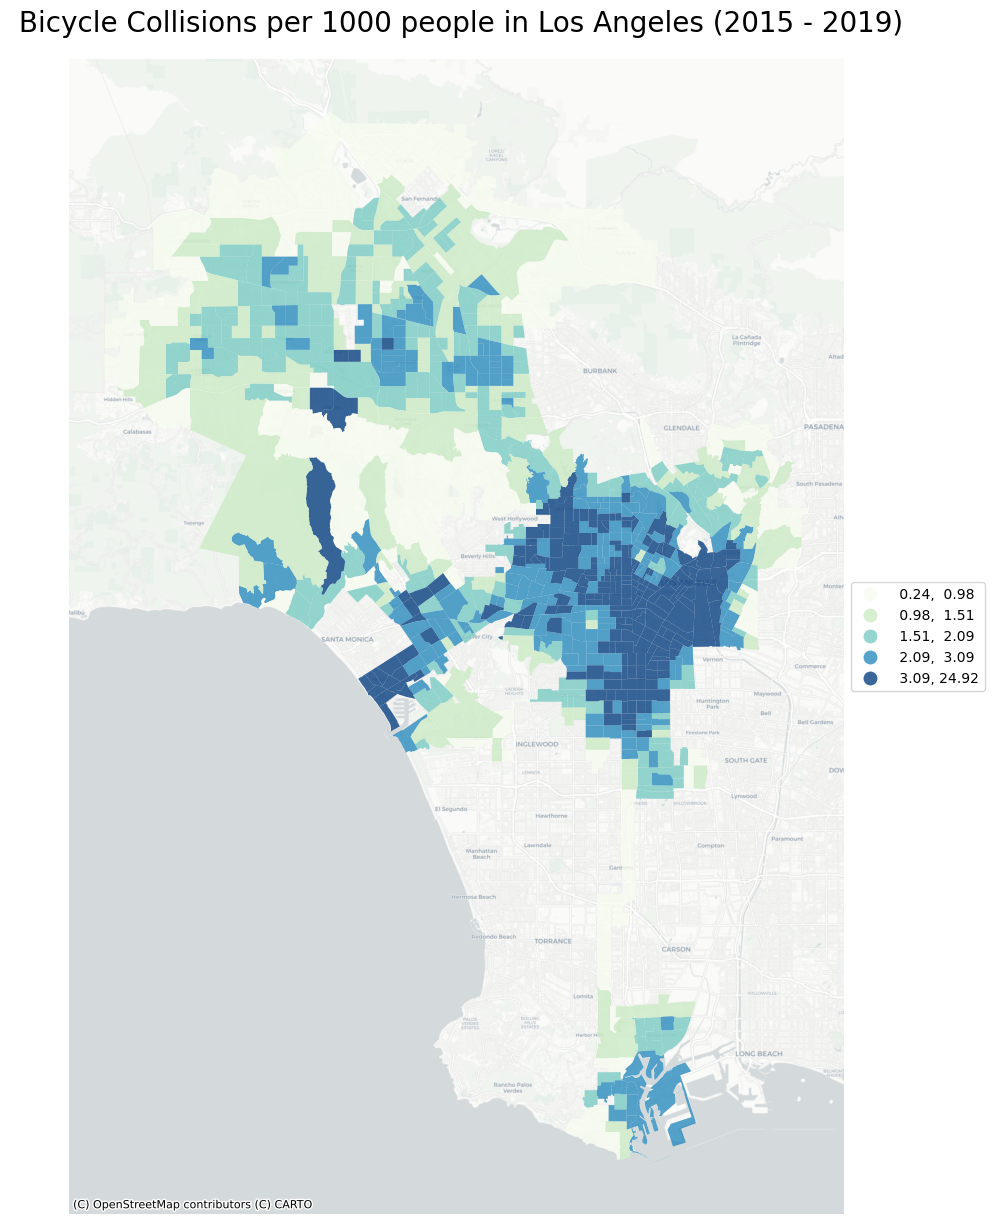

In [50]:
# spatial lag map - mapping the entire dataframe
fig, ax = plt.subplots(figsize=(15, 15))

la_city.plot(ax=ax,
         figsize=(15,15),
         column='collision_per_1000_lag',
         legend=True,
         alpha=0.8,
         cmap='GnBu',
         scheme='quantiles', 
         legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})

ax.axis('off')
ax.set_title(' Bicycle Collisions per 1000 people in Los Angeles (2015 - 2019)',fontsize=20,pad=20)

ctx.add_basemap(ax,zoom =12, source=ctx.providers.CartoDB.Positron)

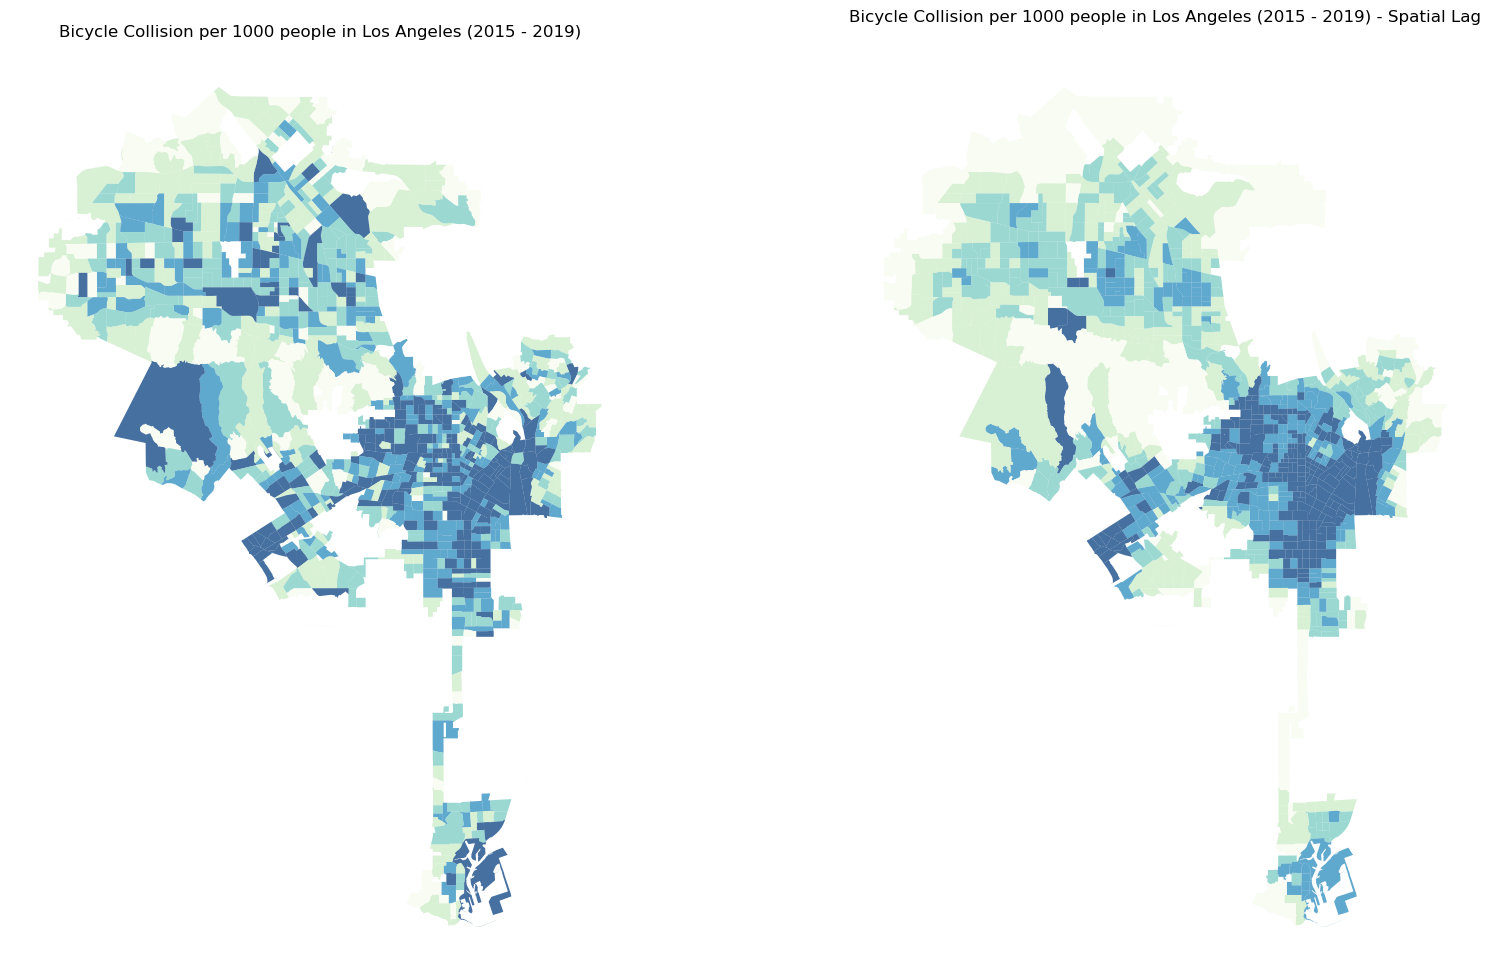

In [51]:
# ploting both collisions per 1000 and lag 
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

#ax[0] - map on the left 
la_city.plot(ax=ax[0], # this assigns the map to the left subplot
         column='collision_per_1000', 
         cmap='GnBu', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Bicycle Collision per 1000 people in Los Angeles (2015 - 2019)")

# ax[1] - map on the right 
la_city.plot(ax=ax[1], 
         column='collision_per_1000_lag', 
         cmap='GnBu', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Bicycle Collision per 1000 people in Los Angeles (2015 - 2019) - Spatial Lag")

plt.show()

## Moran

In [52]:
# quantifying the degree of spatial correlation, output was positive meaning that high collision tracts are located near other high collision tracts and vise versa
y = la_city.collision_per_1000
moran = Moran(y, wq)
moran.I

np.float64(0.16624751539899996)

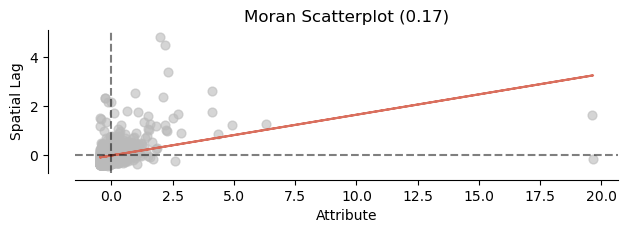

In [53]:
# creating scatterplot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.17', ylabel='Density'>)

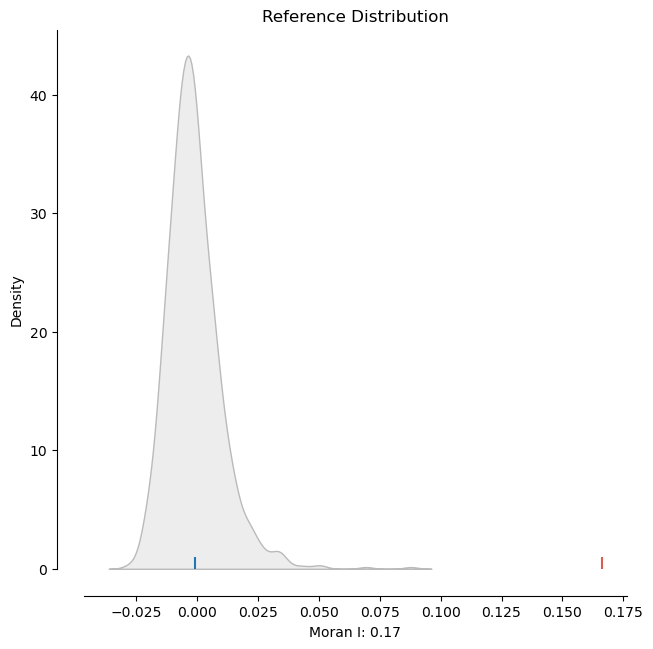

In [54]:
# dcreating reference distribution
plot_moran_simulation(moran,aspect_equal=False)

In [55]:
# p-value , 99% confidence, we are 99% confient that there is statistically significantly spatial clustering with bicycle collisions per 1,000 residents in the City of LA from 2015-2019. 
moran.p_sim

np.float64(0.001)

In [56]:
# moran local scatterplot
lisa = esda.moran.Moran_Local(y, wq)

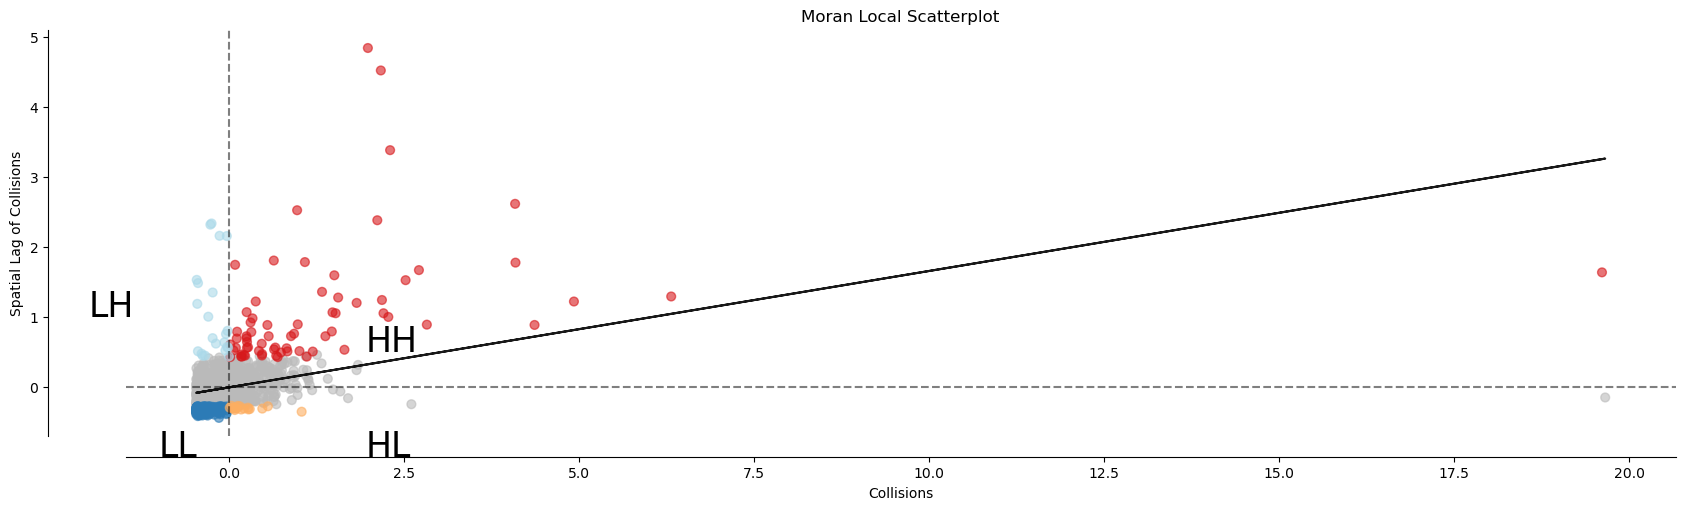

In [57]:
# plot 
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Collisions")
ax.set_ylabel('Spatial Lag of Collisions')

# test
plt.text(1.95, 0.5, "HH", fontsize=25) 
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

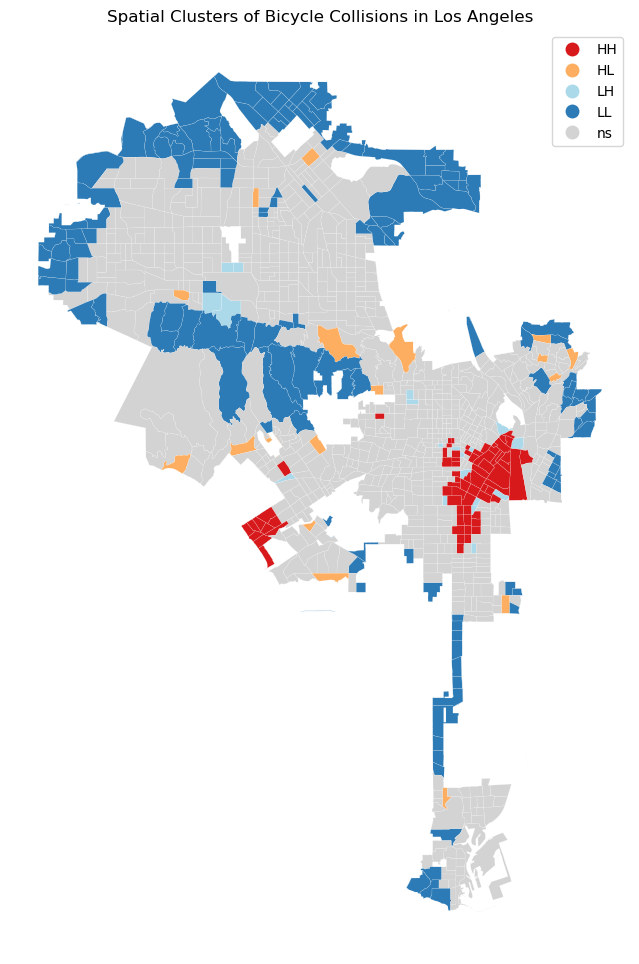

In [58]:
# mapping 
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, la_city, p=0.05, ax=ax) 

ax.set_title("Spatial Clusters of Bicycle Collisions in Los Angeles")

plt.show()

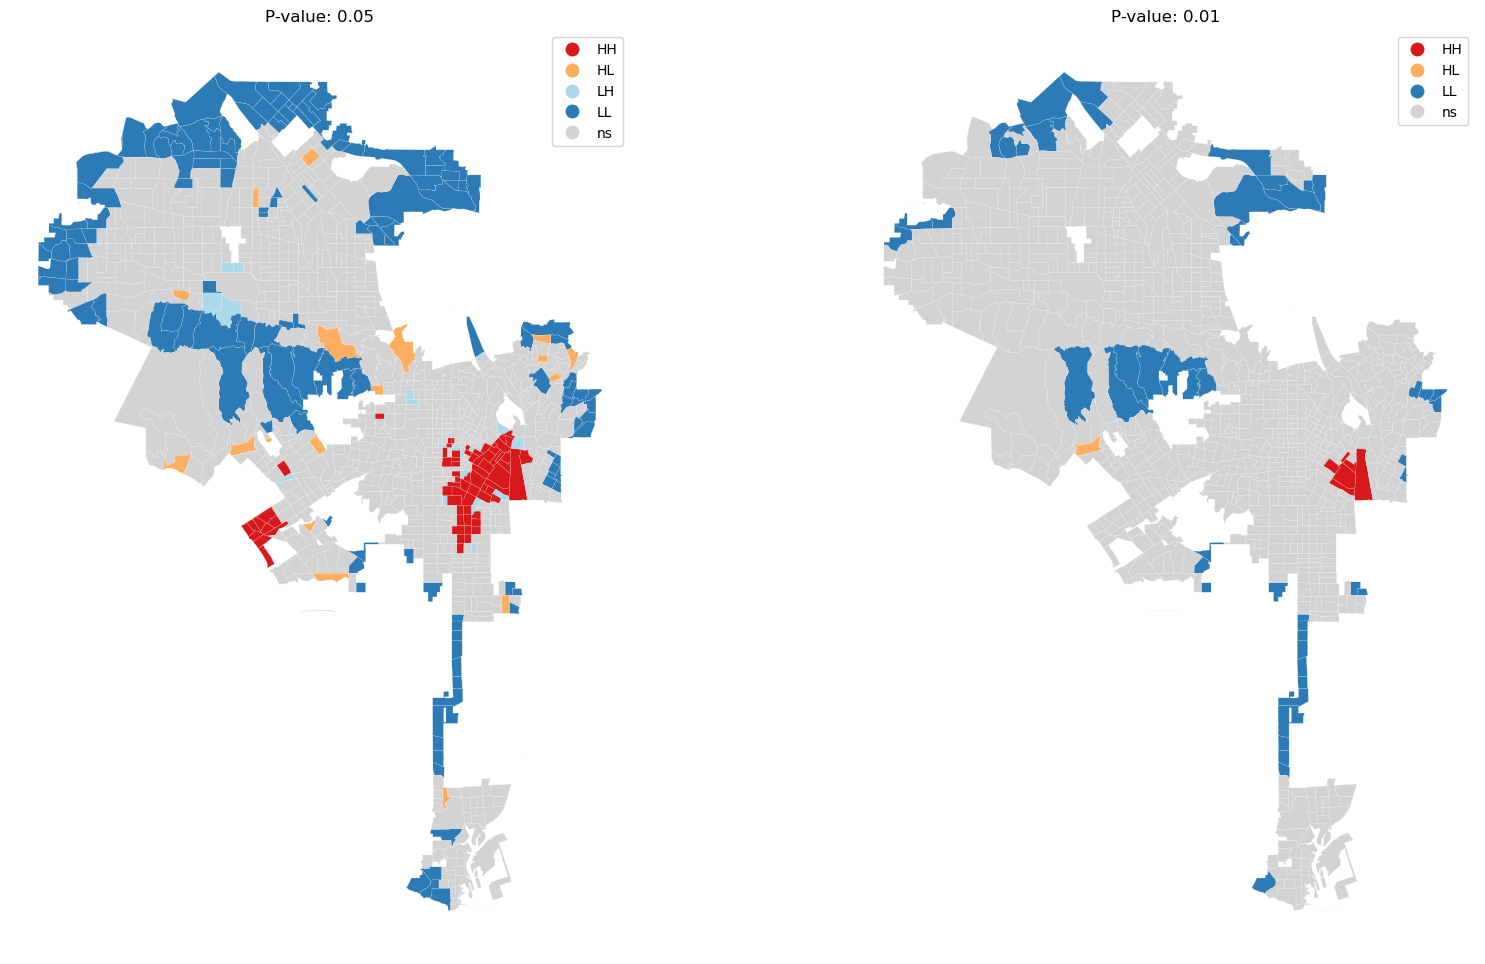

In [59]:
# create maps with different p-values
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
lisa_cluster(lisa,la_city, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, la_city, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

# Team Roles

### Emily

Conducted spatial analysis for fatal pedestrian and bicycle collisions in the City of LA 

### Gema 

Conducted spatial analysis for pedestrian in the City of LA 

### Veronica 
Conducted spatial analysis for bicycle collisions in the City of LA 